In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
import sklearn
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import Sequential, layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error

%matplotlib inline

In [19]:
np.random.seed(1)

In [20]:
train_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv", index_col="Id")
test_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv", index_col="Id")

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [21]:
sample_submission = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")
sample_submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


## Split the data

In [22]:
X = train_df.drop(columns="SalePrice")
y = train_df["SalePrice"]

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
for k, v in {"X_train": X_train, "y_train": y_train, "X_val": X_val, "y_val": y_val}.items():
    print(f"{k} shape = {v.shape}")


X_train shape = (1022, 79)
y_train shape = (1022,)
X_val shape = (438, 79)
y_val shape = (438,)


# Data Preprocessing
    - EDA is done in another notebook (EDA.ipynb)

In [24]:
# Create a copy of the training df to test preprocessing
data = train_df.copy()

In [25]:
def preprocess_data(df, test_df=False):
    # Drop columns with bad or unuseful data
    columns_to_drop = ["Street", "Alley","Utilities", "Condition1", "Condition2", "RoofMatl", "PoolQC", "MiscFeature"]
    df = df.drop(columns=columns_to_drop)
    
    # Transform some numerical columns to remove high skewness
    cols_to_transform = ["MasVnrArea", "BsmtFinSF1", "BsmtUnfSF", "2ndFlrSF", "WoodDeckSF",
                        "OpenPorchSF", "BsmtUnfSF", "BsmtFinSF2", "1stFlrSF", "2ndFlrSF", 
                        "GrLivArea", "MiscVal"]
    
    for i in cols_to_transform:
        df[i] = np.sqrt(df[i] + 1e-8)  
        
    # Reduce cardinality
    rarely_occuring = ["WdShing", "Stucco", "BrkComm", "AsbShng", "Stone", "ImStucc", "CBlock"]

    for i in rarely_occuring:
        df["Exterior1st"] = df["Exterior1st"].str.replace(i, "Other")
        
        
    if test_df:  
        return df
    
    
    X = df.drop(columns="SalePrice")
    y = df["SalePrice"]    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
    for k, v in {"X_train": X_train, "y_train": y_train, "X_val": X_val, "y_val": y_val}.items():
        print(f"{k} shape = {v.shape}")

    return X_train, X_val, y_train, y_val
    

# Building a model

In [29]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()


In [30]:
num_pipeline = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

In [31]:
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

In [32]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_data),
    ("cat", cat_pipeline, cat_data)
])

In [33]:
X_train_nn = preprocessor.fit_transform(X_train)
X_val_nn = preprocessor.transform(X_val)

In [34]:
X_train_nn.shape

(1022, 200)

In [41]:
checkpoint_path = '/best_model2/checkpoint'

best_model = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

In [ ]:
model1 = Sequential([
    layers.Input(shape=(200, )),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    
    layers.Dense(128, activation="relu"),
    layers.Dense(1)
])

model1.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=["mae"]
)

hist = model1.fit(X_train_nn, y_train,
           validation_data=(X_val_nn, y_val),
           epochs=100,
            callbacks=[best_model])

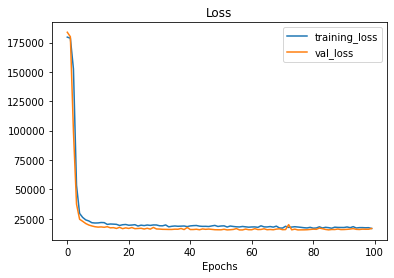

In [43]:
plot_loss_curves(hist)

In [44]:
model1.load_weights(checkpoint_path)

In [45]:
val_preds = model1.predict(X_val_nn)
val_score = mean_absolute_error(y_val, val_preds)

In [46]:
val_score

15435.45935002854

# Making predictions on the test data

In [172]:
X_test = preprocess_data(test_df, True)
X_test_indices = X_test.index
X_test = pd.DataFrame(preprocessor.transform(X_test))

In [173]:
preds_test = model1.predict(X_test).ravel()

In [176]:
output = pd.DataFrame({'Id': X_test_indices,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

In [177]:
pd.read_csv("/kaggle/working/submission.csv")

,Id,SalePrice
0,1461,128823.090
1,1462,156315.250
2,1463,183022.950
3,1464,189309.200
4,1465,183468.000
...,...,...
1454,2915,86764.830
1455,2916,74806.375
1456,2917,163415.730
1457,2918,118917.300


In [170]:
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})